# LLM Agent를 만드는 여정 (3) MultiModal LLM

## 오늘의 목표 : LLM이 이미지를 보고, 그림을 그리는 프롬프트 작성하기

이 시리즈의 세 번째 글로, LLM이 Text가 아닌 이미지를 보고, 이미지를 그려내는 프롬프트를 작성해보도록 하겠습니다.

### Setup

In [29]:
import dotenv
import os
dotenv.load_dotenv("../.env")
if not "OPENAI_API_KEY" in os.environ:
    raise Exception("OPENAI_API_KEY가 환경변수에 존재하지 않습니다.")

## MultiModal LLM이란? 

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*eVuFOQqzU6gnofUI)

LLM은 기본적으로 Text를 받아서, Text를 내뱉는 함수입니다. 하지만 이외에도 이미지, 영상, 음성등을 함께 입력으로 받을 수 있는 모델들이 속속 등장하고 있습니다. 대표적으로  OpenAI의 `GPT-4o`로, 현재 이미지를 입력값으로 받을 수 있도록 지원하고 있습니다.

In [30]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

## LLM으로 이미지 판단하기

아래는 wikipedia에 올라와있는 사진 이미지입니다.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Apples.jpg/320px-Apples.jpg" width="10%"/>

In [3]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Apples.jpg/320px-Apples.jpg"

이미지는 아래와 같은 형식으로 담아서 보내야 합니다.

In [4]:
from langchain.schema import HumanMessage

message = HumanMessage(
    content=[
        {"type": "text", "text": "describe the fruit in this image"},
        {
            "type": "image_url", 
            "image_url": {"url": image_url}
        }
    ]
)

output = llm.invoke([message])
output

AIMessage(content='The image features a variety of apples arranged together. There are green apples, which appear crisp and fresh, and red apples that have varying shades, including some with a deeper red hue and others with a mix of red and yellow. The apples are shiny and smooth, suggesting they are ripe and ready to eat. The overall arrangement showcases a colorful mix of these fruits, creating a vibrant and appealing display.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 8513, 'total_tokens': 8593, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_74ba47b4ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-8e50b19e-4530-4430-b6e0-ce93354a4328-0', usage_metadata={'input_tokens': 8513, 'output_tokens': 80, 'total_tokens': 8593})

### 프롬프트 템플릿화시키기

좀 더 재사용성을 높이기 위해, 프롬프트 템플릿을 작성하겠습니다. 기존 프롬프트 템플릿처럼 f-string방식으로 `{variable_name}` 변수 부분을 지정하면 됩니다.

In [5]:
from langchain.schema import HumanMessage
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate

message_template = HumanMessagePromptTemplate.from_template([{"type": "text", "text": "{instruction}"},{"type": "image_url", "image_url": {"url": "{image_url}"}}])
prompt = ChatPromptTemplate(messages=[message_template], input_variables=["instruction", "image_url"])
prompt

ChatPromptTemplate(input_variables=['image_url', 'instruction'], messages=[HumanMessagePromptTemplate(prompt=[PromptTemplate(input_variables=['instruction'], template='{instruction}'), ImagePromptTemplate(input_variables=['image_url'], template={'url': '{image_url}'})])])

프롬프트를 활용하여 보다 간결하게 llm에게 요청할 수 있습니다.

In [6]:
chain = (prompt | llm)

chain.invoke({
    "instruction": "해당 과일에 대해 설명해주세요.",
    "image_url": image_url
}).content

'해당 과일은 사과입니다. 사과는 다양한 색상과 품종이 있으며, 일반적으로 붉은색, 녹색, 노란색으로 구분됩니다. 사과는 달고 상큼한 맛이 특징이며, 생으로 먹거나 요리, 디저트, 음료 등 여러 방식으로 활용됩니다. 또한, 비타민 C와 식이섬유가 풍부하여 건강에 좋은 과일로 알려져 있습니다. 사과는 또한 항산화 물질이 많이 포함되어 있어 면역력 강화와 심혈관 건강에 도움을 줄 수 있습니다.'

### 로컬에 있는 이미지를 LLM에게 보내기

자신의 컴퓨터에 있는 이미지를 보내려면 어떻게 해야 할까요? 이때도 동일하게 URL를 활용하여 보낼 수 있습니다. 

우선 위키피디아의 바나나 이미지를 로컬 경로 "./banana.jpg"에 저장합니다.

In [7]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Bananas.jpg/640px-Bananas.jpg -O banana.jpg

--2024-09-27 16:17:11--  https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Bananas.jpg/640px-Bananas.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86783 (85K) [image/jpeg]
Saving to: ‘banana.jpg’

banana.jpg          100%[===================>]  84.75K   472KB/s    in 0.2s    

2024-09-27 16:17:12 (472 KB/s) - ‘banana.jpg’ saved [86783/86783]


로컬 컴퓨터에 있는 이미지는 아래와 같이, base64로 인코딩하면 됩니다.

In [8]:
def encode_image_url(file_path:str):
    import base64
    with open(file_path, "rb") as file:
        base64_image = base64.b64encode(file.read()).decode('utf-8')
    
    file_ext = file_path.split(".")[-1] # jpg
    return f"data:image/jpg;base64,{base64_image}"

In [10]:
banana_image_url = encode_image_url("./banana.jpg")

chain.invoke({
    "instruction": "해당 과일에 대해 설명해주세요.",
    "image_url": banana_image_url
})

AIMessage(content='바나나는 세계에서 가장 인기 있는 과일 중 하나로, 주로 열대 및 아열대 지역에서 재배됩니다. 주황색의 껍질을 가진 바나나는 부드럽고 달콤한 과육을 가지고 있으며, 여러 가지 영양소가 풍부합니다. 특히 칼륨과 비타민 C가 많이 포함되어 있어 심혈관 건강에 좋고 에너지원으로 유용합니다.\n\n바나나는 또한 소화에 도움이 되는 식이섬유가 풍부하여 장 건강에도 긍정적인 영향을 미칩니다. 다양한 요리에 활용될 수 있으며, 스무디, 디저트, 빵 등 여러 형태로 조리하여 소비할 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 155, 'prompt_tokens': 14183, 'total_tokens': 14338, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e9627b5346', 'finish_reason': 'stop', 'logprobs': None}, id='run-ac8e1ca7-b993-4d4e-a098-89ec4bb8fffa-0', usage_metadata={'input_tokens': 14183, 'output_tokens': 155, 'total_tokens': 14338})

## 이미지를 그리는 AI Model

openAI에서 제공하는 dall-e는 대표적인 이미지를 그려주는 AI Model 입니다. Langchain에서는 `dalle-image-generator`를 통해 dalle-image-generator Tool을 불러올수 있습니다.

In [ ]:
from langchain.agents import load_tools
tools = load_tools(['dalle-image-generator'])

Dalle의 프롬프트에 데이터들을 밀어넣으면, URL을 반환합니다.

In [12]:
dalle_url = tools[0].invoke("a realistic apple image")

'https://oaidalleapiprodscus.blob.core.windows.net/private/org-g2gmEM6aLsE6kIrQaJlYa9dD/user-o9Oh5qFbf9DOKP6nxrhAtVaa/img-HB08s49rEvcy5iV7bCNjRwQy.png?st=2024-09-27T06%3A17%3A32Z&se=2024-09-27T08%3A17%3A32Z&sp=r&sv=2024-08-04&sr=b&rscd=inline&rsct=image/png&skoid=d505667d-d6c1-4a0a-bac7-5c84a87759f8&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2024-09-26T23%3A16%3A27Z&ske=2024-09-27T23%3A16%3A27Z&sks=b&skv=2024-08-04&sig=gLvpzDjlabksZf1//DuZTLH7lZOCw65UIGaASinWcDI%3D'

Jupyter Notebook에서 확인하려면 아래와 같습니다.

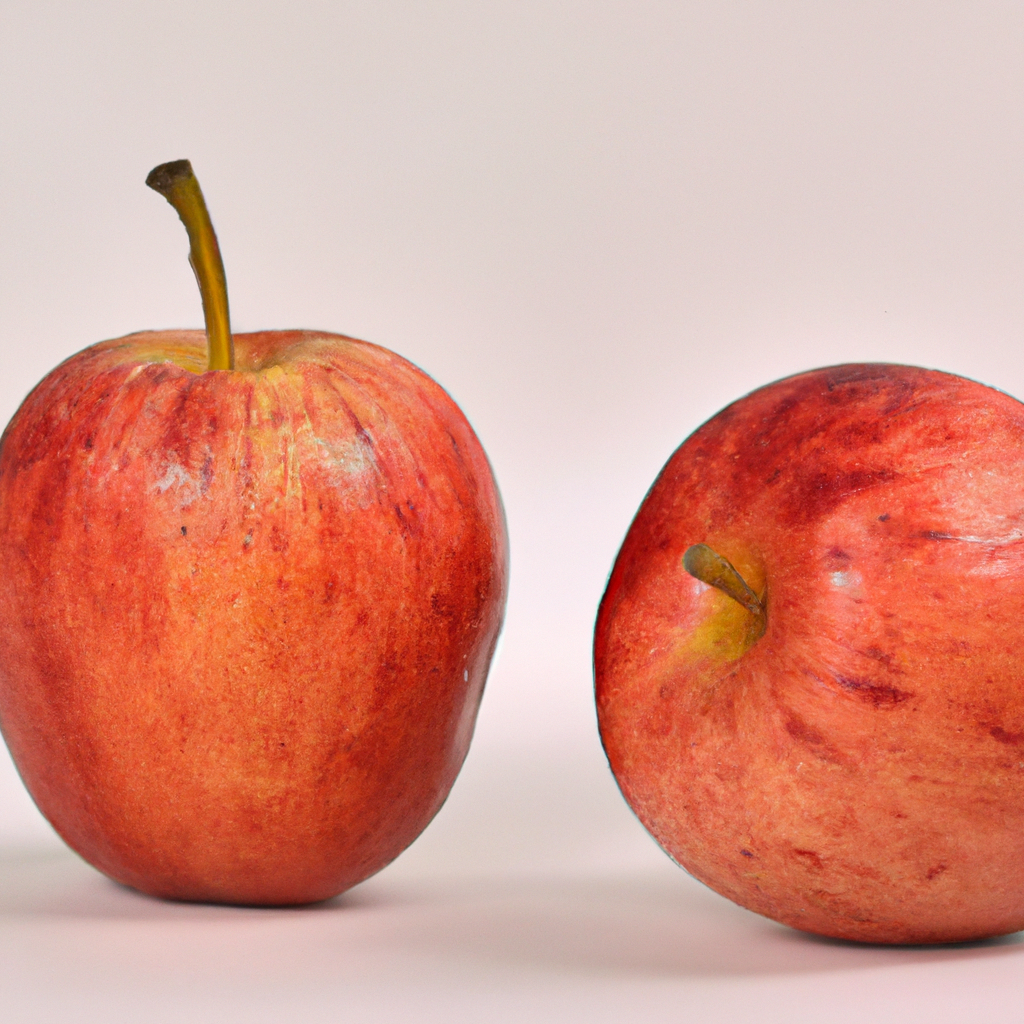

In [13]:
def show_image_from_url(image_url:str):
    from PIL import Image
    import requests
    return Image.open(requests.get(image_url, stream=True).raw)    

show_image_from_url(dalle_url)

### LLM 모델에 연동하기

Dalle와 LLM을 연동해보겠습니다. 이렇게 할 경우, Dalle에 넣을 프롬프트를 LLM 모델에서 만들어서 넣어주는 방식으로 동작합니다.

In [14]:
dalle_llm = llm.bind_tools(tools)

ai_message = dalle_llm.invoke("사과 이미지 그려줘")
ai_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ODwBB2aB9wol3fxCCxZkGYfR', 'function': {'arguments': '{"__arg1":"A realistic and vibrant red apple on a wooden table, with a soft natural light illuminating it, surrounded by green leaves."}', 'name': 'Dall-E-Image-Generator'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 85, 'total_tokens': 129, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-494a34c5-d0f6-4e19-9d53-d1e201e7dce6-0', tool_calls=[{'name': 'Dall-E-Image-Generator', 'args': {'__arg1': 'A realistic and vibrant red apple on a wooden table, with a soft natural light illuminating it, surrounded by green leaves.'}, 'id': 'call_ODwBB2aB9wol3fxCCxZkGYfR', 'type': 'tool_call'}], usage_metadata={'input_tokens': 85, 'output_tokens': 44, 'total_tokens':

위와 같이, dalle 모델이 보다 잘 동작할 수 있도록 구체적인 프롬프트로 변환해서 `tool_calls`을 생성합니다. 이렇게 만든 tool_calls는 아래와 같이 tool에 invoke하여 그 응답값을 받습니다.

In [15]:
from typing import List, Dict
from langchain.tools import Tool
from langchain_core.messages import ToolMessage

def invoke_tool(tool_calls: List[Dict], tools: List[Tool]) -> List[ToolMessage]:
    tool_messages = []
    for tool_call in tool_calls:
        for tool in tools:
            if tool.name == tool_call['name']:
                tool_message = tool.invoke(tool_call)
                tool_messages.append(tool_message)
    return tool_messages

In [16]:
tool_messages = invoke_tool(ai_message.tool_calls, tools)
tool_messages

[ToolMessage(content='https://oaidalleapiprodscus.blob.core.windows.net/private/org-g2gmEM6aLsE6kIrQaJlYa9dD/user-o9Oh5qFbf9DOKP6nxrhAtVaa/img-3kX7Ec59TSEgv0PUFbq7yQDU.png?st=2024-09-27T06%3A17%3A45Z&se=2024-09-27T08%3A17%3A45Z&sp=r&sv=2024-08-04&sr=b&rscd=inline&rsct=image/png&skoid=d505667d-d6c1-4a0a-bac7-5c84a87759f8&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2024-09-26T23%3A36%3A09Z&ske=2024-09-27T23%3A36%3A09Z&sks=b&skv=2024-08-04&sig=eUbdOhlCJLqZf/ufY/4/YbqXJm/A/JxU88BwoWOFE6c%3D', name='Dall-E-Image-Generator', tool_call_id='call_ODwBB2aB9wol3fxCCxZkGYfR')]

## 식자재 이미지를 받아서, 요리 음식을 그리는 프롬프트 작성하기

In [17]:
from langchain.schema import SystemMessage
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

system_template = SystemMessage(content="당신은 요리사입니다. 주어진 식자재 이미지를 활용한 요리에 대한 이미지를 제시하세요.")

message_template = HumanMessagePromptTemplate.from_template([{"type": "text", "text": "요리: {food}"}, {"type": "image_url", "image_url": {"url": "{image_url}"}}])
prompt = ChatPromptTemplate(messages=[system_template, message_template], input_variables=["food", "image_url"])
prompt

ChatPromptTemplate(input_variables=['food', 'image_url'], messages=[SystemMessage(content='당신은 요리사입니다. 주어진 식자재 이미지를 활용한 요리에 대한 이미지를 제시하세요.'), HumanMessagePromptTemplate(prompt=[PromptTemplate(input_variables=['food'], template='요리: {food}'), ImagePromptTemplate(input_variables=['image_url'], template={'url': '{image_url}'})])])

In [18]:
def generate_food_image(food:str, image_url: str):
    chain = (prompt | dalle_llm)
    ai_message = chain.invoke({"food":food, "image_url":image_url})
    tool_messages = invoke_tool(ai_message.tool_calls, tools)
    return tool_messages[0].content

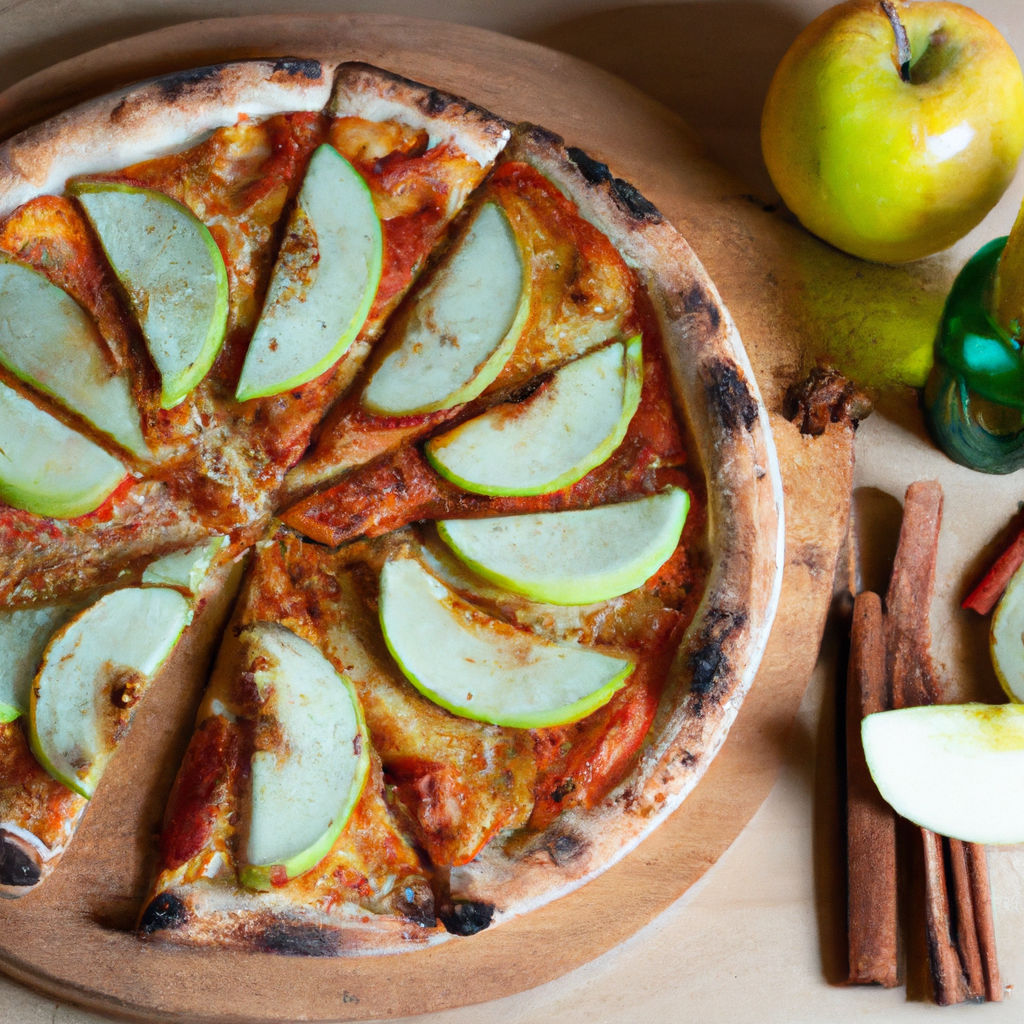

In [19]:
generated_image_url = generate_food_image(
    "피자", "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Apples.jpg/320px-Apples.jpg"
)
show_image_from_url(generated_image_url)

## Additional: 생성한 이미지를 로컬에 저장까지 수행하는 프롬프트

지금은 Dalle를 통해서 이미지를 생성한 후, URL을 통해 접근하고 있습니다. 생성한 이미지를 LLM이 알아서 로컬 컴퓨터에 저장까지 해주면 어떨까요? LLM이 terminal에서 호출할 수 만 있으면 됩니다.

````shell
curl -L <image_url> -O <저장할 경로>
````

즉 LLM에게 Shell Script을 호출할 수 있는 도구를 쥐어주도록 하겠습니다.

In [20]:
from langchain.agents import load_tools

# 참고로 terminal에 접근하는 것은 매우 위험할 수 있으므로, 별도로 allow_dangerous_tools를 지정해주어야 합니다.
tools = load_tools(['dalle-image-generator', 'terminal'],allow_dangerous_tools=True)

image_llm = llm.bind_tools(tools)

In [21]:
from langchain.schema import SystemMessage
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

system_template = SystemMessage(
    content=(
        "당신은 요리사입니다. \n" 
        "- 주어진 식자재 이미지를 활용한 요리에 대한 이미지를 제시하세요. \n" 
        "- 생성한 이미지는 save_path 경로에 다운로드 받으세요. \n"
        "- curl을 통한 이미지 다운로드 시 -L과 user-agent를 추가해주세요 \n" # 해당 옵션이 있어야 정상적으로 다운로드 받는데에 성공하기 때문에, 지시자 추가
    )
)

message_template = HumanMessagePromptTemplate.from_template([{"type": "text", "text": "food: {food}\nsave_path: {save_path}"}, {"type": "image_url", "image_url": {"url": "{image_url}"}}])
prompt = ChatPromptTemplate(messages=[system_template, message_template], input_variables=["food", "save_path", "image_url"])
prompt

ChatPromptTemplate(input_variables=['food', 'image_url', 'save_path'], messages=[SystemMessage(content='당신은 요리사입니다. \n- 주어진 식자재 이미지를 활용한 요리에 대한 이미지를 제시하세요. \n- 생성한 이미지는 save_path 경로에 다운로드 받으세요. \n- curl을 통한 이미지 다운로드 시 -L과 user-agent를 추가해주세요 \n'), HumanMessagePromptTemplate(prompt=[PromptTemplate(input_variables=['food', 'save_path'], template='food: {food}\nsave_path: {save_path}'), ImagePromptTemplate(input_variables=['image_url'], template={'url': '{image_url}'})])])

In [22]:
def generate_and_save_image(food:str, image_url:str, save_path: str):
    prompt_value = prompt.invoke({
        "food": food,
        "image_url": image_url,
        "save_path": save_path
    })
    chat_history = prompt_value.messages

    ai_message = image_llm.invoke(chat_history)
    chat_history.append(ai_message)

    while len(ai_message.tool_calls) > 0:
        # 처리할 tool_call message 발생
        print("[tool_call]\n", ai_message.tool_calls, '\n')

        tool_messages = invoke_tool(ai_message.tool_calls, tools)
        chat_history.extend(tool_messages)
        
        ai_message = image_llm.invoke(chat_history)
        chat_history.append(ai_message)
    
    return ai_message.content

In [23]:
generate_and_save_image(
    food="샐러드", 
    image_url="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Apples.jpg/320px-Apples.jpg",
    save_path="./food_image.png",
)

[tool_call]
 [{'name': 'Dall-E-Image-Generator', 'args': {'__arg1': 'A vibrant salad made with a mix of red and green apples, elegantly arranged on a plate. The salad should have a variety of textures, featuring sliced apples, a sprinkle of nuts, and a drizzle of honey, all set against a fresh green background.'}, 'id': 'call_QjblOjvgpWPG4LglPa4XK7Gp', 'type': 'tool_call'}] 

[tool_call]
 [{'name': 'terminal', 'args': {'commands': ["curl -L -o ./food_image.png 'https://oaidalleapiprodscus.blob.core.windows.net/private/org-g2gmEM6aLsE6kIrQaJlYa9dD/user-o9Oh5qFbf9DOKP6nxrhAtVaa/img-oZPYEn0ddG6SRKdNXRGMwPpY.png?st=2024-09-27T06%3A18%3A15Z&se=2024-09-27T08%3A18%3A15Z&sp=r&sv=2024-08-04&sr=b&rscd=inline&rsct=image/png&skoid=d505667d-d6c1-4a0a-bac7-5c84a87759f8&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2024-09-26T23%3A08%3A47Z&ske=2024-09-27T23%3A08%3A47Z&sks=b&skv=2024-08-04&sig=58HsZ/JB2OLfZ18ofLqL0GTPuVQ%2BaPUDCtXG6UB4ODw%3D'"]}, 'id': 'call_P3yoo0gBUm93lfVvHQbpjeU0', 'type': 'tool_c

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/langchain_community/tools/shell/tool.py:32: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


'The salad image has been successfully generated and saved as `food_image.png`. If you need anything else, feel free to ask!'